In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Install Required Packages

In [2]:
!pip install medmnist
!pip install segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=6e181e4122608457b05f59b89a788e03cbbd9dd72c5574ea2c4dab94aa9b0e45
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=5dac90b6f4c72033df2934f8f2be0dbc0bed481132dd7334158c1939384c4b61
  Stored in directory: 

Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import BreastMNIST
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from torchsummary import summary
import pandas as pd
import segmentation_models_pytorch as smp


Device Configuration

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


Data Transformations

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


Load BreastMNIST Dataset

In [6]:
# Load BreastMNIST dataset
train_data = BreastMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)
val_data = BreastMNIST(split='val', transform=transform, target_transform=lambda x: int(x), download=True)
test_data = BreastMNIST(split='test', transform=transform, target_transform=lambda x: int(x), download=True)


100%|██████████| 560k/560k [00:00<00:00, 782kB/s] 

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


Handle Class Imbalance

In [7]:
train_labels = [label for _, label in train_data]
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


<ipython-input-6-b9f83b897533>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = BreastMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)


Data Loaders

In [8]:
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


Define CNN-RNN Hybrid Model

In [9]:
class CNNRNN(nn.Module):
    def __init__(self):
        super(CNNRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (16, 14, 14)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # Output: (32, 7, 7)
        )
        self.lstm = nn.LSTM(32, 128, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.cnn(x)  # Shape: (batch_size, 32, 7, 7)
        x = x.permute(0, 2, 3, 1)  # Shape: (batch_size, 7, 7, 32)
        x = x.view(batch_size, -1, 32)  # Shape: (batch_size, 49, 32)
        x, _ = self.lstm(x)  # LSTM output: (batch_size, 49, 128)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)  # Output: (batch_size, 2)
        return x


Instantiate Model

In [10]:
cnn_rnn_model = CNNRNN().to(device)


Define Loss Function and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(cnn_rnn_model.parameters(), lr=0.001)


Training Function

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).view(-1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).view(-1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        model.train()


Train the CNN-RNN Model

In [15]:
num_epochs = 10
train_model(cnn_rnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


<ipython-input-6-b9f83b897533>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = BreastMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)
<ipython-input-6-b9f83b897533>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_data = BreastMNIST(split='val', transform=transform, target_transform=lambda x: int(x), download=True)


Epoch 1/10, Train Loss: 0.6687, Train Accuracy: 52.75%, Val Loss: 0.6864, Val Accuracy: 42.31%
Epoch 2/10, Train Loss: 0.6724, Train Accuracy: 37.91%, Val Loss: 0.6849, Val Accuracy: 34.62%
Epoch 3/10, Train Loss: 0.6627, Train Accuracy: 51.83%, Val Loss: 0.7481, Val Accuracy: 73.08%
Epoch 4/10, Train Loss: 0.6608, Train Accuracy: 65.75%, Val Loss: 0.6869, Val Accuracy: 41.03%
Epoch 5/10, Train Loss: 0.6728, Train Accuracy: 40.48%, Val Loss: 0.6882, Val Accuracy: 42.31%
Epoch 6/10, Train Loss: 0.6605, Train Accuracy: 55.31%, Val Loss: 0.6914, Val Accuracy: 53.85%
Epoch 7/10, Train Loss: 0.6728, Train Accuracy: 42.12%, Val Loss: 0.6922, Val Accuracy: 39.74%
Epoch 8/10, Train Loss: 0.6599, Train Accuracy: 49.45%, Val Loss: 0.6918, Val Accuracy: 62.82%
Epoch 9/10, Train Loss: 0.6488, Train Accuracy: 62.82%, Val Loss: 0.6869, Val Accuracy: 46.15%
Epoch 10/10, Train Loss: 0.6488, Train Accuracy: 55.13%, Val Loss: 0.6876, Val Accuracy: 61.54%


Evaluation Function

In [21]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_preds_prob = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).view(-1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, np.array(all_preds_prob)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='yellow', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


Evaluate the CNN-RNN Model

<ipython-input-6-b9f83b897533>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data = BreastMNIST(split='test', transform=transform, target_transform=lambda x: int(x), download=True)


Accuracy: 0.6154
F1 Score: 0.6328
Recall: 0.6154
Precision: 0.6651
Confusion Matrix:
[[21 21]
 [39 75]]


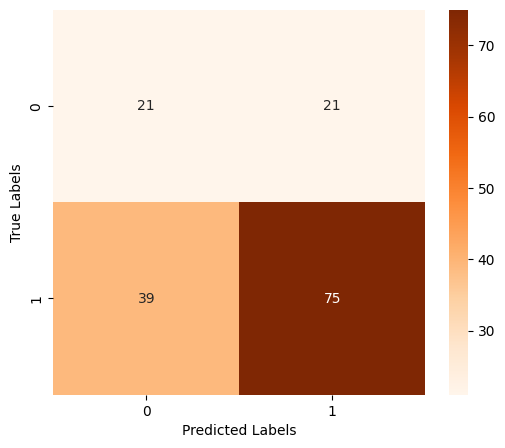

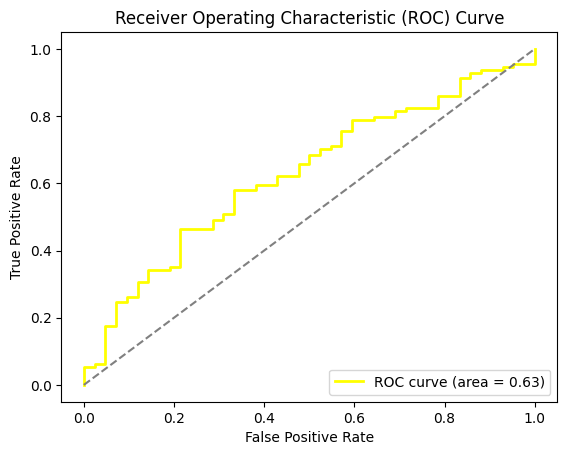

In [22]:
evaluate_model(cnn_rnn_model, test_loader)


Class Distribution Visualization

<ipython-input-6-b9f83b897533>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = BreastMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)


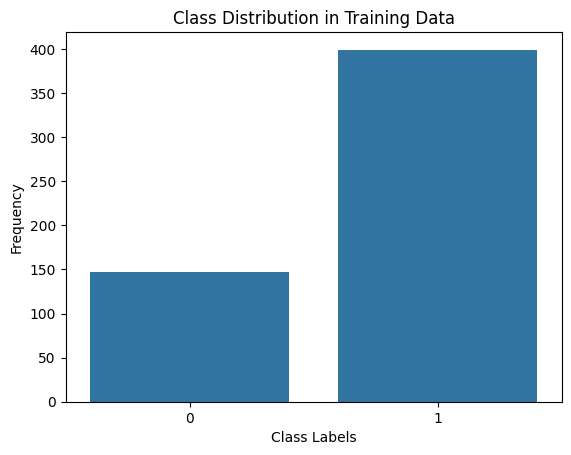

In [25]:
labels = [label for _, label in train_data]
labels_df = pd.DataFrame(labels, columns=['Class'])
sns.countplot(x='Class', data=labels_df)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()


Define DeepLabV3 Model

In [26]:
class DeepLabv3ClassificationModel(nn.Module):
    def __init__(self):
        super(DeepLabv3ClassificationModel, self).__init__()
        # Use the DeepLabV3 with ResNet50 backbone
        self.deeplab = smp.DeepLabV3(
            encoder_name='resnet50',        # Use ResNet-50 as the encoder
            encoder_weights='imagenet',     # Pre-trained on ImageNet
            in_channels=1,                  # Single-channel input (grayscale)
            classes=2                       # Binary classification (not used directly)
        )

        # Global Average Pooling Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer for Classification
        self.fc = nn.Linear(2048, 2)  # Assuming ResNet-50 output feature map has 2048 channels

    def forward(self, x):
        # Forward pass through the encoder of DeepLabV3
        encoder_output = self.deeplab.encoder(x)

        # Ensure the encoder output is correctly extracted
        if isinstance(encoder_output, (tuple, list)):
            x = encoder_output[-1]  # Use the deepest feature map for classification
        else:
            x = encoder_output

        # Now x should be a tensor, suitable for the next layers
        x = self.global_avg_pool(x)  # Apply global average pooling
        x = torch.flatten(x, 1)      # Flatten the feature map to vector
        x = self.fc(x)               # Fully connected layer for classification
        return x


Data Transformations for DeepLabV3

In [27]:
from torchvision.transforms import Resize

# Update Data Transformations to Resize Images to (32, 32)
transform_dl = transforms.Compose([
    Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load BreastMNIST dataset with updated transforms
train_data_dl = BreastMNIST(split='train', transform=transform_dl, target_transform=lambda x: int(x), download=True)
val_data_dl = BreastMNIST(split='val', transform=transform_dl, target_transform=lambda x: int(x), download=True)
test_data_dl = BreastMNIST(split='test', transform=transform_dl, target_transform=lambda x: int(x), download=True)

# Data Loaders
batch_size = 32
train_loader_dl = DataLoader(dataset=train_data_dl, batch_size=batch_size, shuffle=True)
val_loader_dl = DataLoader(dataset=val_data_dl, batch_size=batch_size, shuffle=False)
test_loader_dl = DataLoader(dataset=test_data_dl, batch_size=batch_size, shuffle=False)


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


Handle Class Imbalance for DeepLabV3

In [28]:
train_labels_dl = [label for _, label in train_data_dl]
class_counts_dl = Counter(train_labels_dl)
total_samples_dl = sum(class_counts_dl.values())
class_weights_dl = [total_samples_dl / class_counts_dl[i] for i in range(len(class_counts_dl))]
class_weights_dl = torch.tensor(class_weights_dl, dtype=torch.float).to(device)


<ipython-input-27-35f9cbb28eb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data_dl = BreastMNIST(split='train', transform=transform_dl, target_transform=lambda x: int(x), download=True)


Instantiate DeepLabV3 Model

In [29]:
deeplab_classification_model = DeepLabv3ClassificationModel().to(device)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


Define Loss Function and Optimizer

In [30]:
criterion_dl = nn.CrossEntropyLoss(weight=class_weights_dl)
optimizer_dl = torch.optim.Adam(deeplab_classification_model.parameters(), lr=0.001)


Train the DeepLabV3 Model

In [31]:
train_model(deeplab_classification_model, train_loader_dl, val_loader_dl, criterion_dl, optimizer_dl, num_epochs=10)


<ipython-input-27-35f9cbb28eb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data_dl = BreastMNIST(split='train', transform=transform_dl, target_transform=lambda x: int(x), download=True)
<ipython-input-27-35f9cbb28eb7>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_data_dl = BreastMNIST(split='val', transform=transform_dl, target_transform=lambda x: int(x), download=True)


Epoch 1/10, Train Loss: 0.7528, Train Accuracy: 60.62%, Val Loss: 4.6671, Val Accuracy: 26.92%
Epoch 2/10, Train Loss: 0.5527, Train Accuracy: 68.86%, Val Loss: 0.3887, Val Accuracy: 91.03%
Epoch 3/10, Train Loss: 0.4683, Train Accuracy: 78.39%, Val Loss: 0.4767, Val Accuracy: 85.90%
Epoch 4/10, Train Loss: 0.4008, Train Accuracy: 85.35%, Val Loss: 0.6857, Val Accuracy: 78.21%
Epoch 5/10, Train Loss: 0.5020, Train Accuracy: 81.14%, Val Loss: 0.5180, Val Accuracy: 84.62%
Epoch 6/10, Train Loss: 0.4533, Train Accuracy: 82.05%, Val Loss: 0.3613, Val Accuracy: 88.46%
Epoch 7/10, Train Loss: 0.3851, Train Accuracy: 85.53%, Val Loss: 0.4404, Val Accuracy: 87.18%
Epoch 8/10, Train Loss: 0.4027, Train Accuracy: 87.36%, Val Loss: 0.4829, Val Accuracy: 75.64%
Epoch 9/10, Train Loss: 0.3002, Train Accuracy: 88.46%, Val Loss: 0.3983, Val Accuracy: 80.77%
Epoch 10/10, Train Loss: 0.3353, Train Accuracy: 86.63%, Val Loss: 0.5689, Val Accuracy: 87.18%


Evaluate the DeepLabV3 Model

<ipython-input-27-35f9cbb28eb7>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data_dl = BreastMNIST(split='test', transform=transform_dl, target_transform=lambda x: int(x), download=True)


Accuracy: 0.8077
F1 Score: 0.8091
Recall: 0.8077
Precision: 0.8108
Confusion Matrix:
[[28 14]
 [16 98]]


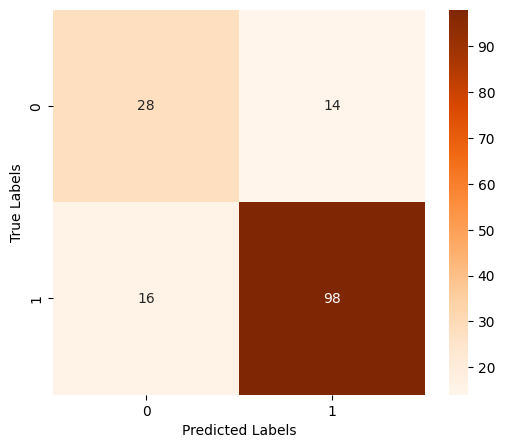

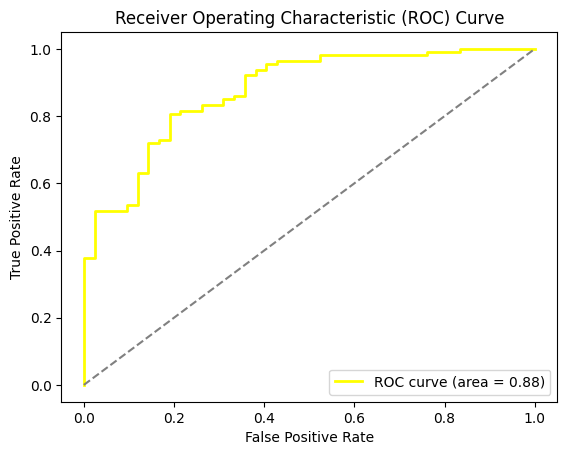

In [32]:
evaluate_model(deeplab_classification_model, test_loader_dl)


Class Distribution Visualization

<ipython-input-27-35f9cbb28eb7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data_dl = BreastMNIST(split='train', transform=transform_dl, target_transform=lambda x: int(x), download=True)


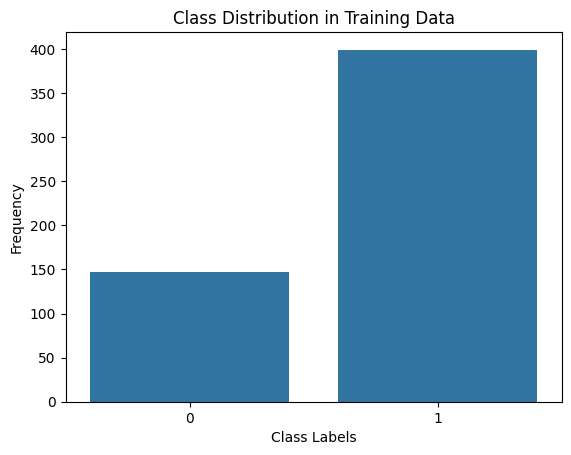

In [33]:
labels_dl = [label for _, label in train_data_dl]
labels_df_dl = pd.DataFrame(labels_dl, columns=['Class'])
sns.countplot(x='Class', data=labels_df_dl)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()


Save Models

In [34]:
# Save the CNN-RNN model
torch.save(cnn_rnn_model.state_dict(), '/content/drive/My Drive/cnn_rnn_breastmnist.pth')

# Save the DeepLabV3 model
torch.save(deeplab_classification_model.state_dict(), '/content/drive/My Drive/deeplab_breastmnist.pth')


Load Models

In [ ]:
# Load the CNN-RNN model
cnn_rnn_model.load_state_dict(torch.load('/content/drive/My Drive/cnn_rnn_breastmnist.pth'))

# Load the DeepLabV3 model
deeplab_classification_model.load_state_dict(torch.load('/content/drive/My Drive/deeplab_breastmnist.pth'))
